# Modelo de Previsão de Churn - Academia

Este notebook demonstra o desenvolvimento e treinamento de um modelo de machine learning para prever a probabilidade de um aluno cancelar sua matrícula na academia.

## Objetivos
- Analisar os dados de frequência dos alunos
- Desenvolver features relevantes para previsão de churn
- Treinar e avaliar diferentes modelos
- Implementar o modelo final na aplicação

In [1]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Configurar visualizações
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## 1. Carregamento e Exploração dos Dados

In [2]:
# Conectar ao banco de dados e carregar dados
import sys
sys.path.append('../')

from app.models.database import SessionLocal
from app.ml.feature_engineering import FeatureEngineer

# Criar sessão do banco
db = SessionLocal()

# Gerar dados de treinamento
feature_engineer = FeatureEngineer(db)

# Tentar usar dados reais, senão usar sintéticos
try:
    df = feature_engineer.create_training_dataset(months_back=12)
    if len(df) < 100:
        print("Dados reais insuficientes. Gerando dados sintéticos...")
        df = feature_engineer.generate_synthetic_data(1000)
        data_source = "sintético"
    else:
        data_source = "real"
except:
    print("Gerando dados sintéticos para demonstração...")
    df = feature_engineer.generate_synthetic_data(1000)
    data_source = "sintético"

print(f"Dataset carregado com {len(df)} amostras ({data_source})")
print(f"Taxa de churn: {df['churn'].mean():.2%}")

# Visualizar primeiras linhas
df.head()

Dados reais insuficientes. Gerando dados sintéticos...
Dataset carregado com 1000 amostras (sintético)
Taxa de churn: 35.70%


,frequencia_semanal,dias_desde_ultimo_checkin,duracao_media_minutos,plano_valor,plano_duracao,dias_como_aluno,churn
0,3.590519,6.390598,57.234714,120,6,82.258164,1
1,3.080228,0.145595,80.210306,80,6,101.133602,0
2,1.548737,3.958759,41.518343,50,12,234.970720,1
3,1.121655,10.765552,31.753926,120,12,359.382347,1
4,3.397608,0.093476,76.649237,50,6,300.813112,0


In [3]:
# Informações gerais do dataset
print("Informações do Dataset:")
print(f"Shape: {df.shape}")
print(f"\nTipos de dados:")
print(df.dtypes)
print(f"\nValores ausentes:")
print(df.isnull().sum())
print(f"\nEstatísticas descritivas:")
df.describe()

Informações do Dataset:
Shape: (1000, 7)

Tipos de dados:
frequencia_semanal           float64
dias_desde_ultimo_checkin    float64
duracao_media_minutos        float64
plano_valor                    int64
plano_duracao                  int64
dias_como_aluno              float64
churn                          int64
dtype: object

Valores ausentes:
frequencia_semanal           0
dias_desde_ultimo_checkin    0
duracao_media_minutos        0
plano_valor                  0
plano_duracao                0
dias_como_aluno              0
churn                        0
dtype: int64

Estatísticas descritivas:


,frequencia_semanal,dias_desde_ultimo_checkin,duracao_media_minutos,plano_valor,plano_duracao,dias_como_aluno,churn
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.098400,6.947119,59.918098,111.200000,5.932000,196.005191,0.357000
std,2.230612,6.618372,20.137590,56.332347,4.430237,96.812215,0.479355
min,0.024182,0.002328,2.705802,50.000000,1.000000,30.174326,0.000000
25%,1.492083,2.052324,46.564121,50.000000,1.000000,111.868664,0.000000
50%,2.647117,4.904575,60.282549,80.000000,6.000000,197.699030,0.000000
75%,4.223440,9.725701,73.644383,120.000000,12.000000,280.250993,1.000000
max,15.578213,42.648236,112.628808,200.000000,12.000000,363.541134,1.000000


## 2. Análise Exploratória dos Dados

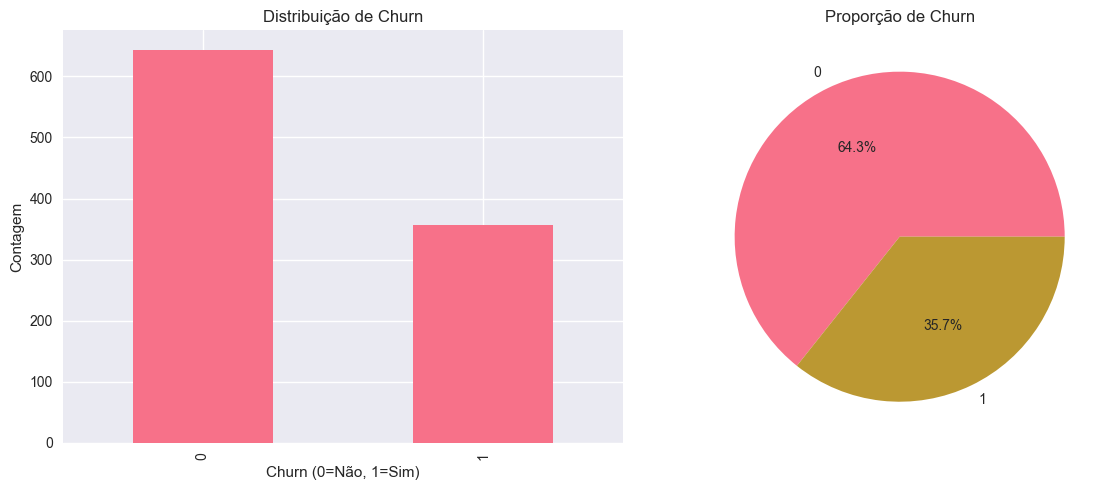

In [4]:
# Distribuição da variável target
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Contagem
df['churn'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribuição de Churn')
axes[0].set_xlabel('Churn (0=Não, 1=Sim)')
axes[0].set_ylabel('Contagem')

# Proporção
df['churn'].value_counts(normalize=True).plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Proporção de Churn')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

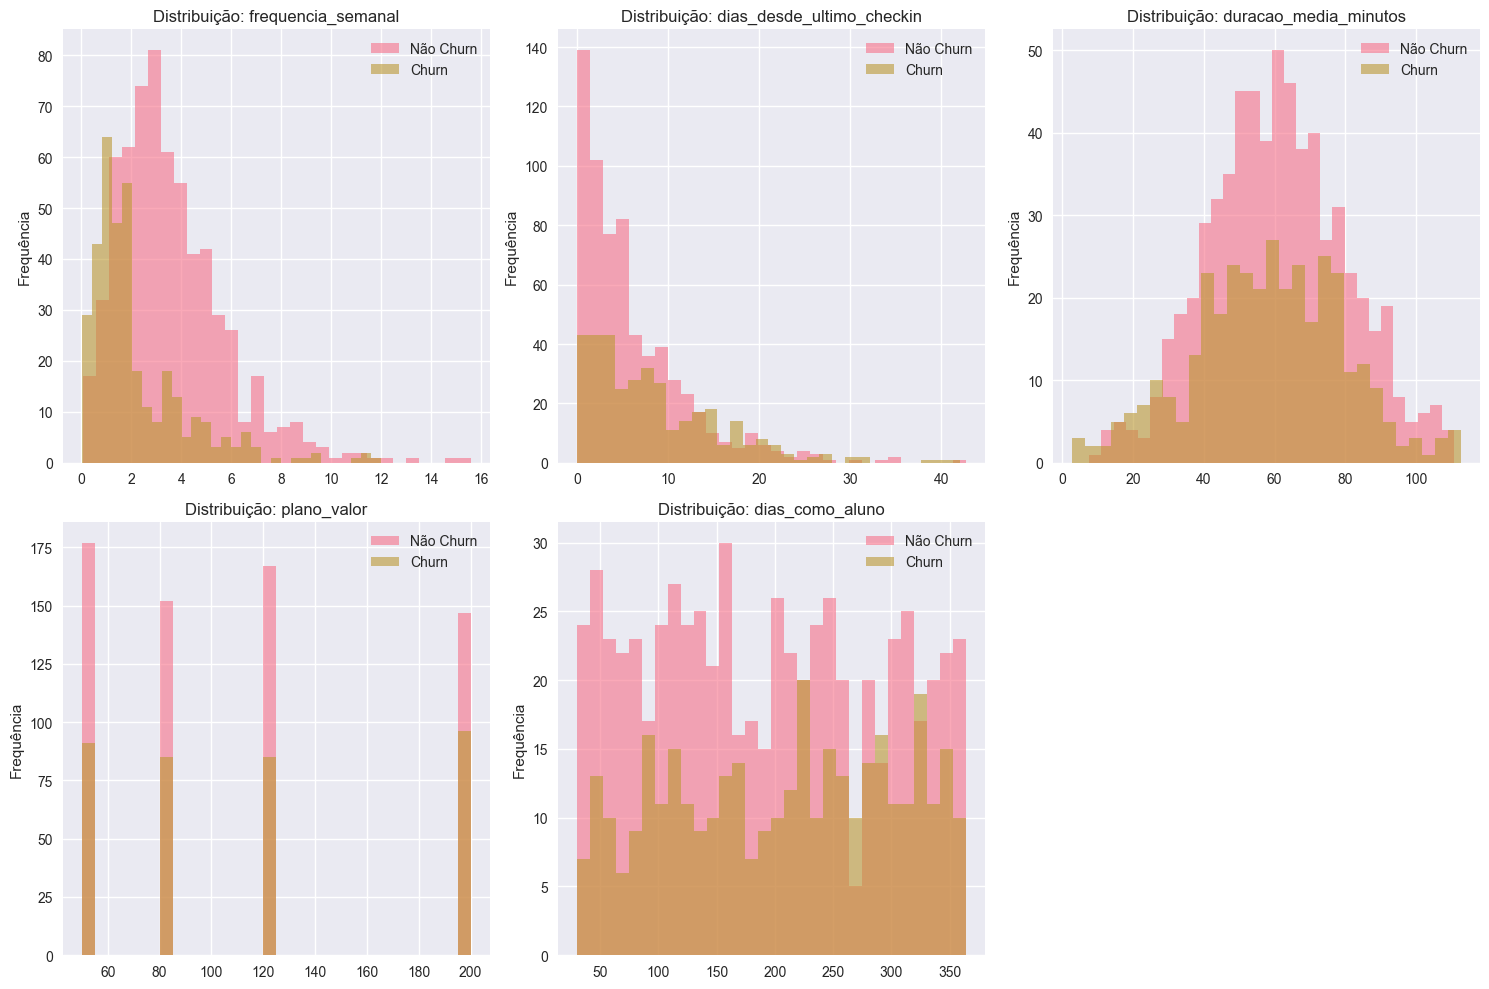

In [5]:
# Distribuição das features numéricas
numeric_features = ['frequencia_semanal', 'dias_desde_ultimo_checkin', 
                   'duracao_media_minutos', 'plano_valor', 'dias_como_aluno']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    # Histograma separado por churn
    df[df['churn']==0][feature].hist(alpha=0.6, label='Não Churn', bins=30, ax=axes[i])
    df[df['churn']==1][feature].hist(alpha=0.6, label='Churn', bins=30, ax=axes[i])
    axes[i].set_title(f'Distribuição: {feature}')
    axes[i].legend()
    axes[i].set_ylabel('Frequência')

# Remover subplot vazio
axes[5].remove()

plt.tight_layout()
plt.show()

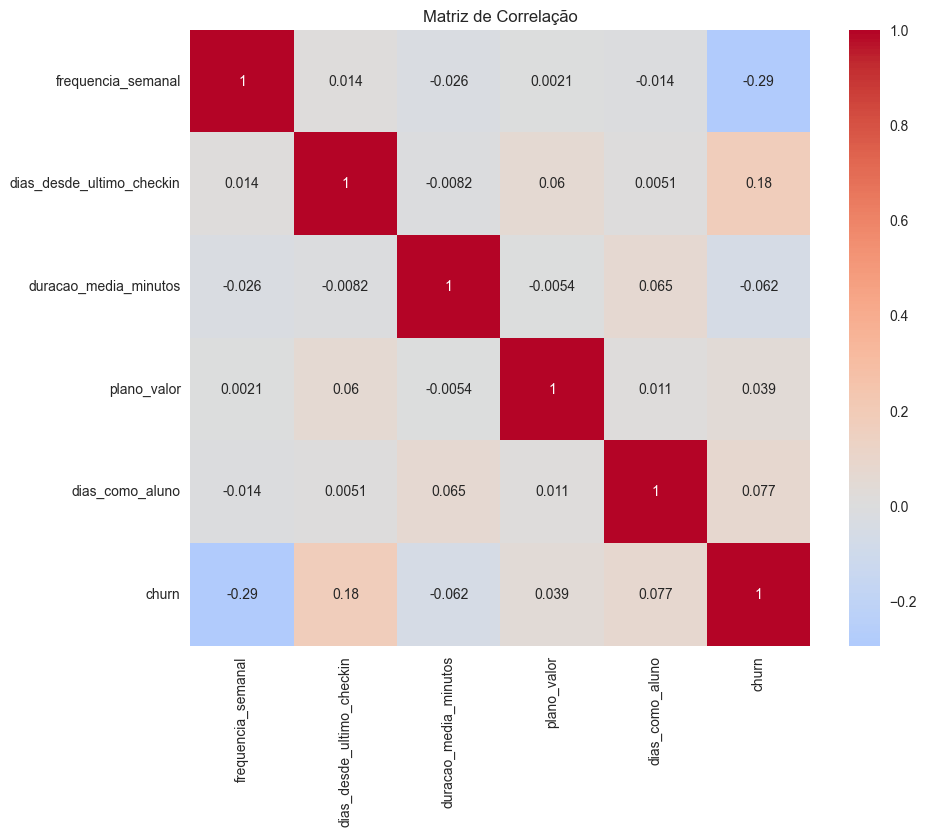

In [6]:
# Correlação entre features
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_features + ['churn']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

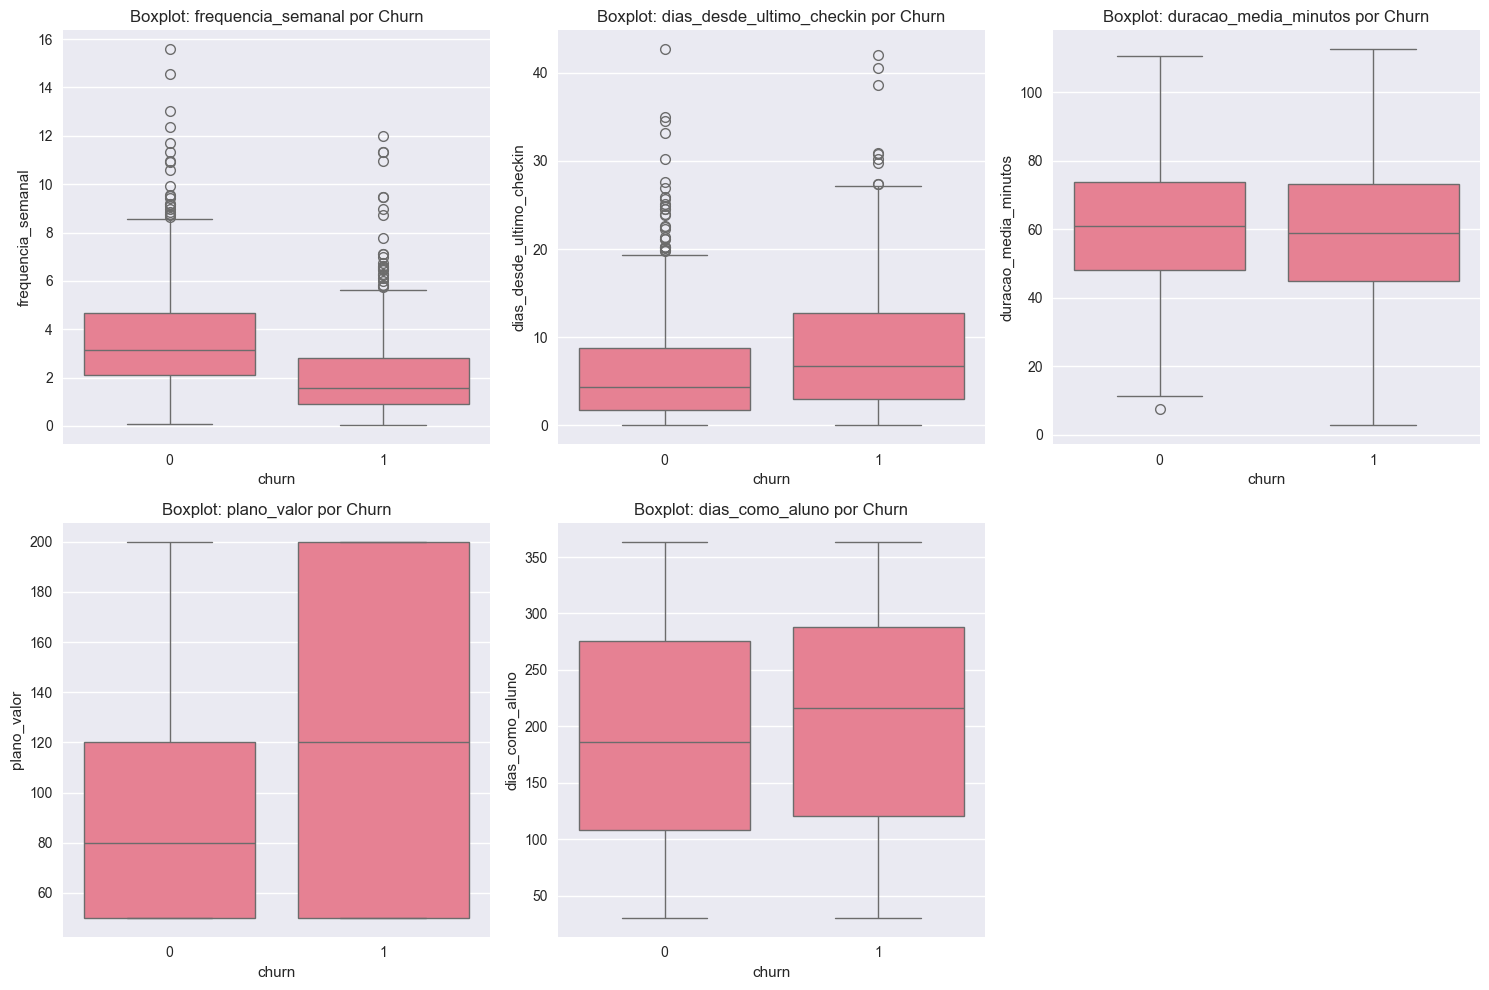

In [7]:
# Boxplots para identificar diferenças entre grupos
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    sns.boxplot(data=df, x='churn', y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot: {feature} por Churn')

axes[5].remove()
plt.tight_layout()
plt.show()

## 3. Preparação dos Dados

In [8]:
# Preparar features e target
feature_columns = ['frequencia_semanal', 'dias_desde_ultimo_checkin', 
                  'duracao_media_minutos', 'plano_valor', 
                  'plano_duracao', 'dias_como_aluno']

X = df[feature_columns]
y = df['churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures utilizadas: {feature_columns}")

Features shape: (1000, 6)
Target shape: (1000,)

Features utilizadas: ['frequencia_semanal', 'dias_desde_ultimo_checkin', 'duracao_media_minutos', 'plano_valor', 'plano_duracao', 'dias_como_aluno']


In [9]:
# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")
print(f"Taxa de churn no treino: {y_train.mean():.2%}")
print(f"Taxa de churn no teste: {y_test.mean():.2%}")

Treino: 800 amostras
Teste: 200 amostras
Taxa de churn no treino: 35.75%
Taxa de churn no teste: 35.50%


In [10]:
# Normalizar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features normalizadas com sucesso!")
print(f"Média das features normalizadas: {X_train_scaled.mean(axis=0)}")
print(f"Desvio padrão das features normalizadas: {X_train_scaled.std(axis=0)}")

Features normalizadas com sucesso!
Média das features normalizadas: [-1.28785871e-16  7.54951657e-17 -1.02140518e-16  2.66453526e-17
 -1.52100554e-16  1.82076576e-16]
Desvio padrão das features normalizadas: [1. 1. 1. 1. 1. 1.]


## 4. Treinamento e Avaliação de Modelos

Logistic Regression: 0.734 (+/- 0.125)
Random Forest: 0.764 (+/- 0.070)
Gradient Boosting: 0.746 (+/- 0.092)


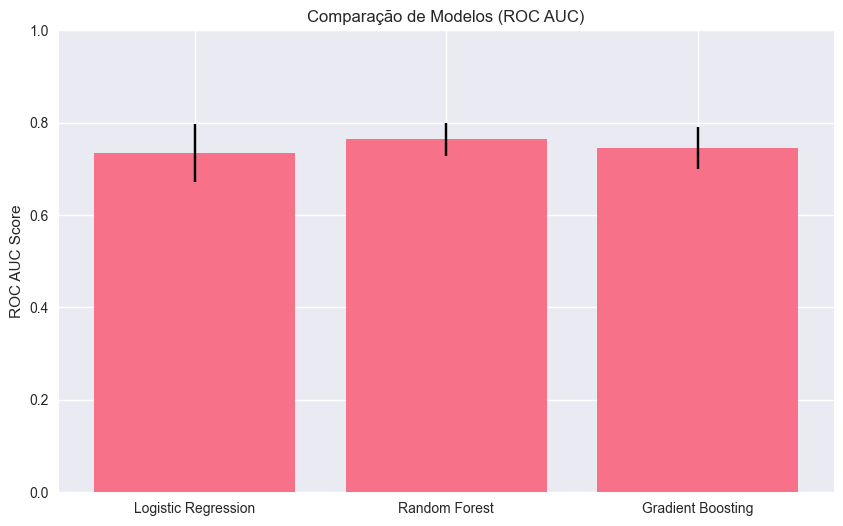

In [11]:
# Definir modelos para comparação
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Avaliar modelos com validação cruzada
cv_results = {}

for name, model in models.items():
    # Para modelos lineares, usar dados normalizados
    if 'Logistic' in name:
        X_train_model = X_train_scaled
    else:
        X_train_model = X_train
    
    # Validação cruzada
    cv_scores = cross_val_score(model, X_train_model, y_train, cv=5, scoring='roc_auc')
    cv_results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"{name}: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Visualizar resultados
plt.figure(figsize=(10, 6))
model_names = list(cv_results.keys())
means = [cv_results[name]['mean'] for name in model_names]
stds = [cv_results[name]['std'] for name in model_names]

plt.bar(model_names, means, yerr=stds, capsize=5)
plt.title('Comparação de Modelos (ROC AUC)')
plt.ylabel('ROC AUC Score')
plt.ylim(0, 1)
plt.show()

In [12]:
# Treinar o melhor modelo (Random Forest)
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

# Fazer previsões
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Avaliar modelo
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.85      0.81       129
           1       0.66      0.52      0.58        71

    accuracy                           0.73       200
   macro avg       0.71      0.69      0.69       200
weighted avg       0.73      0.73      0.73       200


ROC AUC Score: 0.748


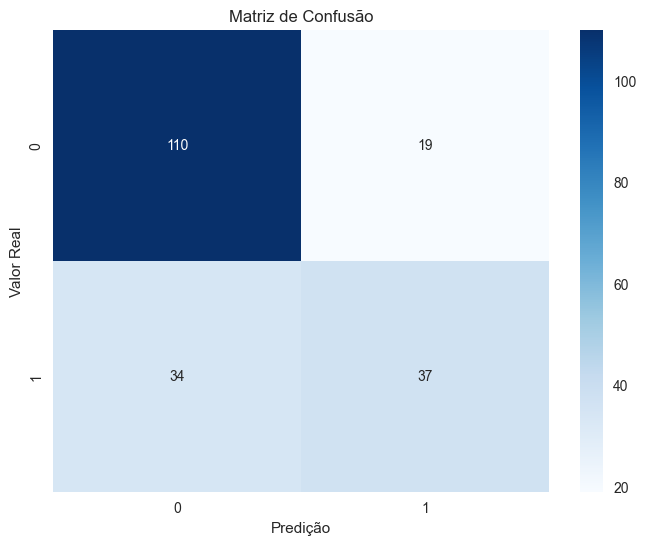

In [13]:
# Matriz de confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Predição')
plt.show()

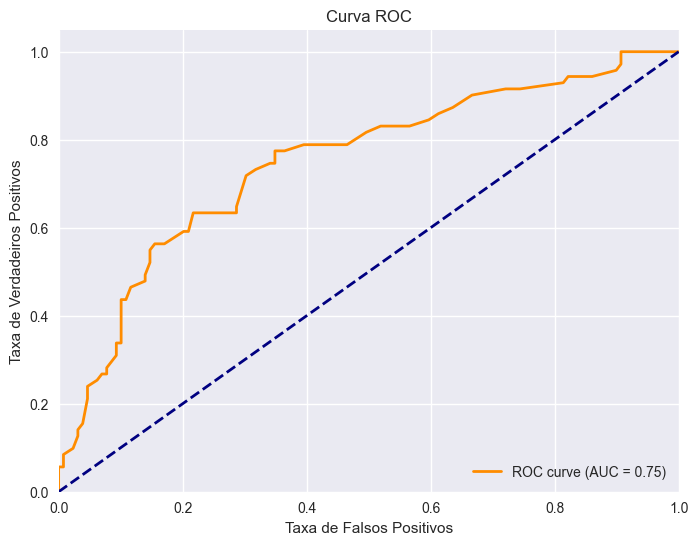

In [14]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## 5. Análise de Importância das Features

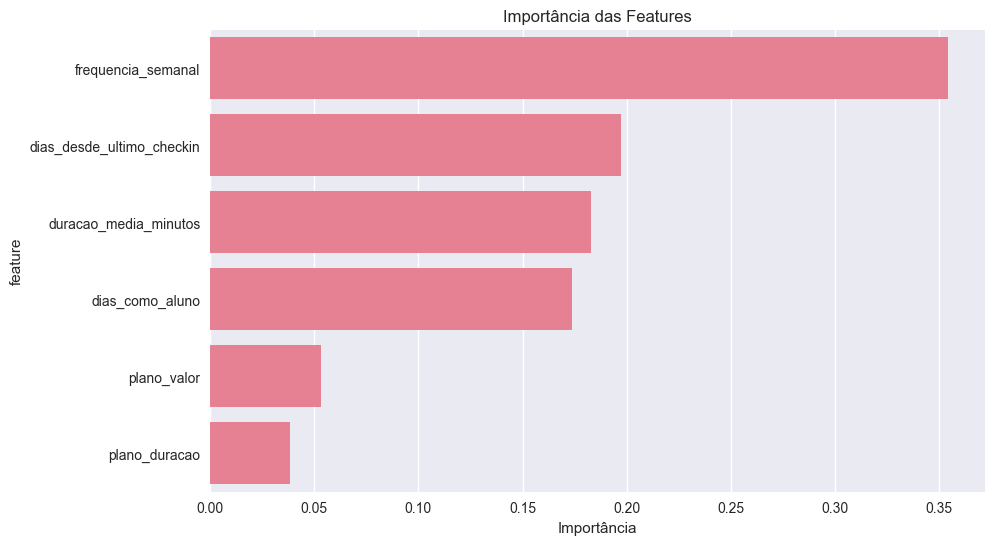

Ranking de Importância das Features:
1. frequencia_semanal: 0.354
2. dias_desde_ultimo_checkin: 0.197
3. duracao_media_minutos: 0.183
4. dias_como_aluno: 0.174
5. plano_valor: 0.053
6. plano_duracao: 0.039


In [15]:
# Importância das features
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Importância das Features')
plt.xlabel('Importância')
plt.show()

print("Ranking de Importância das Features:")
for i, (_, row) in enumerate(feature_importance.iterrows(), 1):
    print(f"{i}. {row['feature']}: {row['importance']:.3f}")

## 6. Otimização de Hiperparâmetros

In [16]:
# Grid search para otimização
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search com validação cruzada
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Melhores parâmetros:")
print(grid_search.best_params_)
print(f"\nMelhor score: {grid_search.best_score_:.3f}")

Melhores parâmetros:
{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

Melhor score: 0.775


In [17]:
# Treinar modelo otimizado
optimized_model = grid_search.best_estimator_
y_pred_opt = optimized_model.predict(X_test)
y_pred_proba_opt = optimized_model.predict_proba(X_test)[:, 1]

print("Modelo Otimizado - Relatório de Classificação:")
print(classification_report(y_test, y_pred_opt))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba_opt):.3f}")

Modelo Otimizado - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       129
           1       0.66      0.56      0.61        71

    accuracy                           0.74       200
   macro avg       0.72      0.70      0.71       200
weighted avg       0.73      0.74      0.74       200


ROC AUC Score: 0.762


## 7. Análise de Exemplos

In [19]:
# Analisar alguns exemplos específicos
test_df = X_test.copy()
test_df['real_churn'] = y_test.values
test_df['pred_churn'] = y_pred_opt
test_df['prob_churn'] = y_pred_proba_opt

# Exemplos de alto risco corretamente identificados
high_risk_correct = test_df[
    (test_df['real_churn'] == 1) & 
    (test_df['prob_churn'] > 0.7)
].head()

print("Exemplos de Alto Risco Corretamente Identificados:")
print(high_risk_correct[['frequencia_semanal', 'dias_desde_ultimo_checkin', 
                        'duracao_media_minutos', 'prob_churn']].round(3))

# Falsos positivos (predito como churn, mas não cancelou)
false_positives = test_df[
    (test_df['real_churn'] == 0) & 
    (test_df['prob_churn'] > 0.7)
].head()

print("\nFalsos Positivos (Alta Probabilidade, mas Não Cancelou):")
print(false_positives[['frequencia_semanal', 'dias_desde_ultimo_checkin', 
                      'duracao_media_minutos', 'prob_churn']].round(3))

Exemplos de Alto Risco Corretamente Identificados:
     frequencia_semanal  dias_desde_ultimo_checkin  duracao_media_minutos  \
546               0.938                     15.686                 46.014   
814               0.693                      3.124                 57.328   
246               1.480                     11.816                 90.891   
722               1.880                      8.031                 15.633   
579               0.954                     12.301                 45.715   

     prob_churn  
546       0.862  
814       0.822  
246       0.702  
722       0.765  
579       0.886  

Falsos Positivos (Alta Probabilidade, mas Não Cancelou):
     frequencia_semanal  dias_desde_ultimo_checkin  duracao_media_minutos  \
51                0.343                      6.082                 63.610   
513               0.298                      9.745                 60.792   
333               1.468                     12.926                 30.453   
210         

## 8. Salvamento do Modelo

In [20]:
# Salvar modelo e scaler
import joblib
import os

# Criar diretório se não existir
os.makedirs('../models', exist_ok=True)

# Salvar modelo
joblib.dump(optimized_model, '../models/churn_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

print("Modelo salvo com sucesso!")
print(f"Localização: ../models/churn_model.pkl")
print(f"Scaler: ../models/scaler.pkl")

Modelo salvo com sucesso!
Localização: ../models/churn_model.pkl
Scaler: ../models/scaler.pkl


## 9. Simulação de Previsões

In [21]:
# Simular previsões para novos alunos
novos_alunos = pd.DataFrame({
    'frequencia_semanal': [3.5, 1.2, 0.5, 4.0],
    'dias_desde_ultimo_checkin': [2, 15, 45, 1],
    'duracao_media_minutos': [75, 45, 20, 90],
    'plano_valor': [120, 80, 50, 200],
    'plano_duracao': [12, 6, 1, 12],
    'dias_como_aluno': [180, 90, 200, 30]
})

# Fazer previsões
previsoes = optimized_model.predict_proba(novos_alunos)[:, 1]

# Adicionar previsões ao DataFrame
novos_alunos['prob_churn'] = previsoes
novos_alunos['risco'] = pd.cut(previsoes, bins=[0, 0.3, 0.7, 1.0], 
                              labels=['Baixo', 'Médio', 'Alto'])

print("Previsões para Novos Alunos:")
print(novos_alunos.round(3))

Previsões para Novos Alunos:
   frequencia_semanal  dias_desde_ultimo_checkin  duracao_media_minutos  \
0                 3.5                          2                     75   
1                 1.2                         15                     45   
2                 0.5                         45                     20   
3                 4.0                          1                     90   

   plano_valor  plano_duracao  dias_como_aluno  prob_churn  risco  
0          120             12              180       0.208  Baixo  
1           80              6               90       0.764   Alto  
2           50              1              200       0.858   Alto  
3          200             12               30       0.131  Baixo  
